# NNで株価を予測モデルを作成する

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pandas_profiling as pdp
import seaborn as sns
%matplotlib inline


# LSTMモデルを組む

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# データセットを作る
## PytorchのLSTMに学習させるためのデータは次元の工夫が必要であり、二重リストのようなかたちになる

In [4]:
window = 15   # データは日足

df_train_law = pd.read_csv('./data/three_year_stock_data.csv' ,index_col=0)
df_train_law.head()
inp_dim = len(df_train_law)

open = df_train_law.open.values
nd_cast = open.astype(np.float32)

X_train, y_train, X_test, y_test= [], [], [], []
tmp = []

for i in nd_cast:
    tmp.append([i])

for i in range(inp_dim - window):
    X_train.append(tmp[i:i+window])
    y_train.append(tmp[i+window])

In [5]:
print( len(X_train[0]) )
print( len(X_train) )

print(X_train[0])
print(X_train[1])
print(X_train[2])
print(y_train[0])
print(y_train[1])

15
689
[[19790.0], [20100.0], [19850.0], [19910.0], [19860.0], [19760.0], [19660.0], [19710.0], [19560.0], [19240.0], [19550.0], [19540.0], [19450.0], [19290.0], [19570.0]]
[[20100.0], [19850.0], [19910.0], [19860.0], [19760.0], [19660.0], [19710.0], [19560.0], [19240.0], [19550.0], [19540.0], [19450.0], [19290.0], [19570.0], [19740.0]]
[[19850.0], [19910.0], [19860.0], [19760.0], [19660.0], [19710.0], [19560.0], [19240.0], [19550.0], [19540.0], [19450.0], [19290.0], [19570.0], [19740.0], [19960.0]]
[19740.0]
[19960.0]


In [6]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

## Dataを組むまでの流れ
1. Datasetクラスを作成する 
    1. 入力データと正解データにわける tensorにすること pd->np->tensorに変換する必要がある
    1. \__len__と\__getitem__を用意すること
1. Dataloaderを準備  
Datasetクラスで作ったやつをinputするだけなので難易度は低い
    

 ### datasetクラスを作成する

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,  X , y , mode='train' ,transform = None):
        self.data = X
        self.label = y
        self.num = len(X)
        self.mode= mode
        self.transform = transform
       
    
    def __len__(self):                         ###データの大きさをreturn するlenメソッドを必ず作成する必要がある
        return self.num
    
    def __getitem__(self, idx):           ###正解データと入力データが対となるようなgetitemメソッドを必ず作成する必要がある
        
        out_data = self.data[idx]
        out_label =  self.label[idx]
        
        return out_data, out_label
        

### XとyをDatasetクラスを継承させて作った自作クラスにinput

In [8]:
trainset = Dataset( X_train , y_train )

In [9]:
dataloader = torch.utils.data.DataLoader(dataset=trainset, batch_size = 4, shuffle=True)   

### 中身の確認

In [10]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [11]:
X.shape

torch.Size([4, 15, 1])

In [12]:
print(X[1].shape)
print(X[1])
print(labal[1])

torch.Size([15, 1])
tensor([[23310.],
        [23200.],
        [22460.],
        [22400.],
        [22250.],
        [21830.],
        [21870.],
        [22010.],
        [22380.],
        [22300.],
        [21990.],
        [21840.],
        [21700.],
        [21360.],
        [20870.]])
tensor([20020.])


## モデルの構築

In [13]:
import torch
import torch.nn as nn


class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.lstm = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        
        output, (hidden, cell) = self.lstm(inputs, hidden0) #LSTM層
        output = self.output_layer(output[:, -1, :]) #全結合層

        return output


In [14]:
model = Predictor(1,100,1)    # inputの次元は? 株価onlyだから1次元となるのか、それとも時間を5個分とってくるから 5次元？？
model

Predictor(
  (lstm): LSTM(1, 100)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)

In [15]:
# 損失関数
criterion = nn.MSELoss()      ### 損失化関数は二乗誤差を設定。　回帰モデルなのでOK
# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)     ### lrは学習率

In [16]:
ls_loss = []

for epoch in range(3):
    
    model.train()
    for i, (X, label) in enumerate(dataloader):

        X.long()
        label.long()

        print("=======")
        print(label)
        
        # 勾配の初期化
        optimizer.zero_grad()     
        
        y_pred = model( X )          ### ニューラルネットで計算したoutputを保存
        
        print("y_pred : ",y_pred)
        
        loss = criterion(y_pred, label) ###教師データとoutputから損失関数を計算
        
        # バッチごとのロスを記録する
        ls_loss.append(loss)
        
        # 勾配の計算
        loss.backward()           ### 損失関数を微分 = 勾配の計算
        
        # パラメータの更新
        optimizer.step()           
        
        #print('*** by optimizer.step()')
       # print(model.lstm.weight)
    

tensor([[25040.],
        [21560.],
        [21500.],
        [24390.]])
y_pred :  tensor([[0.0917],
        [0.1012],
        [0.1026],
        [0.1028]], grad_fn=<AddmmBackward>)
tensor([[20900.],
        [22310.],
        [22880.],
        [21060.]])
y_pred :  tensor([[8645.9521],
        [9252.6064],
        [9345.5889],
        [9358.3984]], grad_fn=<AddmmBackward>)
tensor([[19660.],
        [22470.],
        [22940.],
        [24840.]])
y_pred :  tensor([[13378.7559],
        [14318.9902],
        [14463.1006],
        [14482.9551]], grad_fn=<AddmmBackward>)
tensor([[22130.],
        [22870.],
        [21800.],
        [22350.]])
y_pred :  tensor([[16505.2656],
        [17668.1621],
        [17846.4004],
        [17870.9551]], grad_fn=<AddmmBackward>)
tensor([[22700.],
        [23190.],
        [19860.],
        [23010.]])
y_pred :  tensor([[18302.3906],
        [19590.7559],
        [19788.2266],
        [19815.4297]], grad_fn=<AddmmBackward>)
tensor([[21780.],
        [22260.],

tensor([[21160.],
        [21850.],
        [23450.],
        [20590.]])
y_pred :  tensor([[20983.0312],
        [22412.1719],
        [22631.2188],
        [22661.3984]], grad_fn=<AddmmBackward>)
tensor([[19420.],
        [21080.],
        [20370.],
        [20440.]])
y_pred :  tensor([[20826.0293],
        [22243.3965],
        [22460.6348],
        [22490.5645]], grad_fn=<AddmmBackward>)
tensor([[21710.],
        [22860.],
        [23150.],
        [22490.]])
y_pred :  tensor([[20195.8047],
        [21568.3789],
        [21778.7539],
        [21807.7383]], grad_fn=<AddmmBackward>)
tensor([[23060.],
        [23220.],
        [21050.],
        [23530.]])
y_pred :  tensor([[20648.6172],
        [22052.6797],
        [22267.8828],
        [22297.5312]], grad_fn=<AddmmBackward>)
tensor([[20350.],
        [22130.],
        [22740.],
        [21190.]])
y_pred :  tensor([[20975.3223],
        [22400.5117],
        [22618.9512],
        [22649.0449]], grad_fn=<AddmmBackward>)
tensor([[23610.

y_pred :  tensor([[20727.6055],
        [22071.7520],
        [22277.7715],
        [22306.1523]], grad_fn=<AddmmBackward>)
tensor([[22960.],
        [22000.],
        [21700.],
        [20370.]])
y_pred :  tensor([[20765.8574],
        [22109.2598],
        [22315.1641],
        [22343.5312]], grad_fn=<AddmmBackward>)
tensor([[19880.],
        [20430.],
        [19840.],
        [20040.]])
y_pred :  tensor([[20704.0410],
        [22040.2266],
        [22245.0234],
        [22273.2383]], grad_fn=<AddmmBackward>)
tensor([[20270.],
        [22610.],
        [22300.],
        [21240.]])
y_pred :  tensor([[20036.0430],
        [21324.0156],
        [21521.4258],
        [21548.6211]], grad_fn=<AddmmBackward>)
tensor([[20530.],
        [20560.],
        [22810.],
        [20750.]])
y_pred :  tensor([[20223.1797],
        [21524.5000],
        [21723.9570],
        [21751.4355]], grad_fn=<AddmmBackward>)
tensor([[21570.],
        [20000.],
        [23140.],
        [20790.]])
y_pred :  tenso

y_pred :  tensor([[20855.4766],
        [22125.4785],
        [22320.1348],
        [22346.9512]], grad_fn=<AddmmBackward>)
tensor([[23060.],
        [22340.],
        [20900.],
        [19550.]])
y_pred :  tensor([[21060.3418],
        [22342.7031],
        [22539.2500],
        [22566.3281]], grad_fn=<AddmmBackward>)
tensor([[19890.],
        [22440.],
        [21960.],
        [23300.]])
y_pred :  tensor([[20794.1191],
        [22054.3359],
        [22247.4922],
        [22274.1016]], grad_fn=<AddmmBackward>)
tensor([[22610.],
        [21550.],
        [20620.],
        [21630.]])
y_pred :  tensor([[20820.5098],
        [22083.7207],
        [22277.3340],
        [22304.0078]], grad_fn=<AddmmBackward>)
tensor([[21860.],
        [22160.],
        [22380.],
        [21950.]])
y_pred :  tensor([[20707.2070],
        [21959.9707],
        [22151.9824],
        [22178.4375]], grad_fn=<AddmmBackward>)
tensor([[23120.],
        [19840.],
        [23320.],
        [22130.]])
y_pred :  tenso

y_pred :  tensor([[21207.0039],
        [22436.6758],
        [22625.1484],
        [22651.1133]], grad_fn=<AddmmBackward>)
tensor([[19200.],
        [23220.],
        [21970.],
        [22400.]])
y_pred :  tensor([[21358.3613],
        [22596.4434],
        [22786.2051],
        [22812.3496]], grad_fn=<AddmmBackward>)
tensor([[22380.],
        [22690.],
        [22640.],
        [23030.]])
y_pred :  tensor([[21107.8086],
        [22329.8281],
        [22517.1289],
        [22542.9336]], grad_fn=<AddmmBackward>)
tensor([[23280.],
        [20630.],
        [23130.],
        [23150.]])
y_pred :  tensor([[21313.4023],
        [22549.0625],
        [22738.4512],
        [22764.5449]], grad_fn=<AddmmBackward>)
tensor([[23540.],
        [23550.],
        [20560.],
        [19870.]])
y_pred :  tensor([[21381.3984],
        [22620.0508],
        [22809.8984],
        [22836.0547]], grad_fn=<AddmmBackward>)
tensor([[22490.],
        [21150.],
        [23460.],
        [20800.]])
y_pred :  tenso

y_pred :  tensor([[21704.5098],
        [22888.0957],
        [23069.5020],
        [23094.4961]], grad_fn=<AddmmBackward>)
tensor([[23770.],
        [19670.],
        [23200.],
        [22160.]])
y_pred :  tensor([[21371.8867],
        [22529.3594],
        [22706.7656],
        [22731.2070]], grad_fn=<AddmmBackward>)
tensor([[21030.],
        [19960.],
        [19830.],
        [20560.]])
y_pred :  tensor([[21307.8574],
        [22458.1738],
        [22634.4824],
        [22658.7754]], grad_fn=<AddmmBackward>)
tensor([[22130.],
        [23250.],
        [23490.],
        [23240.]])
y_pred :  tensor([[20579.3711],
        [21676.4922],
        [21844.6504],
        [21867.8164]], grad_fn=<AddmmBackward>)
tensor([[19920.],
        [23080.],
        [22210.],
        [24230.]])
y_pred :  tensor([[21154.0449],
        [22291.5957],
        [22465.9473],
        [22489.9707]], grad_fn=<AddmmBackward>)
tensor([[22380.],
        [21730.],
        [19650.],
        [23440.]])
y_pred :  tenso

tensor([[21220.],
        [23620.],
        [19800.],
        [19850.]])
y_pred :  tensor([[21240.5078],
        [22331.3359],
        [22498.5293],
        [22521.5625]], grad_fn=<AddmmBackward>)
tensor([[23200.],
        [19880.],
        [19960.],
        [20000.]])
y_pred :  tensor([[20848.2402],
        [21909.8223],
        [22072.5293],
        [22094.9473]], grad_fn=<AddmmBackward>)
tensor([[20420.],
        [22930.],
        [20510.],
        [23580.]])
y_pred :  tensor([[20464.6484],
        [21495.3281],
        [21653.3008],
        [21675.0645]], grad_fn=<AddmmBackward>)
tensor([[23390.],
        [21580.],
        [23220.],
        [22580.]])
y_pred :  tensor([[20669.0684],
        [21714.7344],
        [21875.0059],
        [21897.0840]], grad_fn=<AddmmBackward>)
tensor([[19920.],
        [21930.],
        [23390.],
        [21560.]])
y_pred :  tensor([[21092.1738],
        [22165.9199],
        [22330.4941],
        [22353.1660]], grad_fn=<AddmmBackward>)
tensor([[18840.

tensor([[22040.],
        [24600.],
        [20590.],
        [20610.]])
y_pred :  tensor([[21467.2695],
        [22535.1602],
        [22698.8359],
        [22721.3828]], grad_fn=<AddmmBackward>)
tensor([[20150.],
        [22260.],
        [24390.],
        [22080.]])
y_pred :  tensor([[21310.8887],
        [22366.1523],
        [22527.8945],
        [22550.1758]], grad_fn=<AddmmBackward>)
tensor([[19730.],
        [22780.],
        [20890.],
        [23500.]])
y_pred :  tensor([[21330.0547],
        [22388.1270],
        [22550.3008],
        [22572.6426]], grad_fn=<AddmmBackward>)
tensor([[24000.],
        [23590.],
        [22930.],
        [20380.]])
y_pred :  tensor([[21154.7500],
        [22201.7266],
        [22362.1992],
        [22384.3066]], grad_fn=<AddmmBackward>)
tensor([[23380.],
        [23490.],
        [23220.],
        [22160.]])
y_pred :  tensor([[21402.2988],
        [22463.9238],
        [22626.6406],
        [22649.0566]], grad_fn=<AddmmBackward>)
tensor([[20470.

y_pred :  tensor([[21001.7520],
        [21982.0957],
        [22132.3535],
        [22153.0547]], grad_fn=<AddmmBackward>)
tensor([[20460.],
        [23010.],
        [24360.],
        [22040.]])
y_pred :  tensor([[21113.9746],
        [22101.0898],
        [22252.3867],
        [22273.2305]], grad_fn=<AddmmBackward>)
tensor([[21390.],
        [20900.],
        [19930.],
        [22330.]])
y_pred :  tensor([[21320.2461],
        [22323.2500],
        [22476.9805],
        [22498.1602]], grad_fn=<AddmmBackward>)
tensor([[21120.],
        [23740.],
        [22020.],
        [23000.]])
y_pred :  tensor([[20933.1211],
        [21907.6328],
        [22056.9961],
        [22077.5742]], grad_fn=<AddmmBackward>)
tensor([[23370.],
        [20440.],
        [22610.],
        [22560.]])
y_pred :  tensor([[21207.4414],
        [22201.7461],
        [22354.1445],
        [22375.1406]], grad_fn=<AddmmBackward>)
tensor([[22960.],
        [22960.],
        [23140.],
        [20940.]])
y_pred :  tenso

tensor([[23140.],
        [22300.],
        [23610.],
        [24490.]])
y_pred :  tensor([[21275.2129],
        [22223.7129],
        [22369.0898],
        [22389.1172]], grad_fn=<AddmmBackward>)
tensor([[23990.],
        [23190.],
        [21730.],
        [21850.]])
y_pred :  tensor([[21767.3828],
        [22750.0898],
        [22900.7109],
        [22921.4609]], grad_fn=<AddmmBackward>)
tensor([[21190.],
        [23220.],
        [21940.],
        [22390.]])
y_pred :  tensor([[21793.1367],
        [22775.0000],
        [22925.4922],
        [22946.2246]], grad_fn=<AddmmBackward>)
tensor([[22410.],
        [21190.],
        [22460.],
        [23590.]])
y_pred :  tensor([[21634.4180],
        [22605.1797],
        [22753.9688],
        [22774.4688]], grad_fn=<AddmmBackward>)
tensor([[21660.],
        [20000.],
        [22390.],
        [21050.]])
y_pred :  tensor([[21619.6016],
        [22588.5840],
        [22737.1016],
        [22757.5625]], grad_fn=<AddmmBackward>)
tensor([[19980.

### ロスの確認

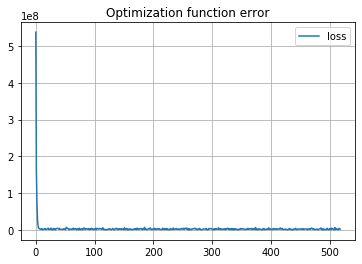

In [17]:
plt.figure()
plt.plot(ls_loss,label="loss")
plt.title('Optimization function error') # 最適化関数の誤差
plt.legend()
plt.grid()

## できあがったmodelでテストを行ってみる

In [112]:
test

NameError: name 'test' is not defined

In [87]:
X_pd_test = test.drop('log_price',  axis=1)
y_pd_test = test['log_price']

In [88]:
X_pd_test = X_pd_test.values
y_pd_test = y_pd_test.values

X_pd_test = torch.from_numpy(X_pd_test.astype(np.float32)).clone()
y_pd_test = torch.from_numpy(y_pd_test.astype(np.float32)).clone()

In [89]:
testset = PdDataset( X_pd_test , y_pd_test )
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size = 32, shuffle=True)

In [90]:
#model.train()
for i, (inputPd, pricePd) in enumerate(testset):

    print("@@@@@@@@@@@@", i)
    
    print(inputPd)
    
    y = model(inputPd)

    print("y_pred : ",y)
    
    if i==4:
        break

@@@@@@@@@@@@ 0
tensor([0.0000, 0.1539, 0.0000, 0.9425, 0.1905, 0.0315])
y_pred :  tensor([2.9495], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 1
tensor([1.0000, 0.0402, 0.0000, 0.0637, 0.0000, 0.9484])
y_pred :  tensor([3.1888], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 2
tensor([0.0000, 0.8875, 0.0000, 1.0000, 0.9368, 0.1176])
y_pred :  tensor([3.5809], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 3
tensor([1.0000, 0.9762, 0.0000, 0.0622, 0.0000, 0.1023])
y_pred :  tensor([3.0982], grad_fn=<SqueezeBackward3>)
@@@@@@@@@@@@ 4
tensor([1.0000, 0.2645, 0.0000, 0.0249, 0.7989, 0.2553])
y_pred :  tensor([2.7945], grad_fn=<SqueezeBackward3>)
